1. Линейная регрессия
$$
y = b_0 + b_1x
$$
2. Полиномиальная регрессия второй степени
$$
y = b_0 + b_1x + b_2x^2
$$
3. Полиномиальная регрессия третьей степени
$$
y = b_0 + b_1x + b_2x^2 + b_3x^3
$$


| Степень полинома | Результат    |
|------------------|--------------|
| Слишком малая    | Underfitting |
| Слишком большая  | Overfitting  |

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [31]:
n = 120
X = np.linspace(-4, 6, n).reshape(-1, 1)
noise = np.random.normal(0, 6, n)
y = 0.5 * X.flatten()**3 - 3 * X.flatten()**2 + 2 * X.flatten() + noise

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
len(X_train), len(X_test)

(90, 30)

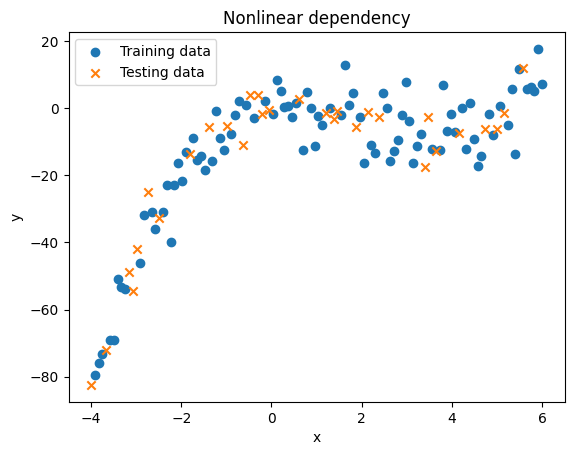

In [32]:
plt.figure()
plt.scatter(X_train, y_train, label="Training data")
plt.scatter(X_test, y_test, label="Testing data", marker="x")
plt.title("Nonlinear dependency")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

In [33]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

y_predict_train = lin_model.predict(X_train)
y_predict_test = lin_model.predict(X_test)

r2_lin_train = r2_score(y_train, y_predict_train)
r2_lin_test = r2_score(y_test, y_predict_test)

rmse_lin_train = mean_squared_error(y_train, y_predict_train)**0.5
rmse_lin_test = mean_squared_error(y_test, y_predict_test)**0.5

print("Linear regression:")
print(f" Train R^2: {r2_lin_train: .3f}, Test R^2: {r2_lin_test: .3f}")
print(f" Train RMSE: {rmse_lin_train: .3f}, Test RMSE: {rmse_lin_test: .3f}")


Linear regression:
 Train R^2:  0.451, Test R^2:  0.455
 Train RMSE:  15.144, Test RMSE:  16.787


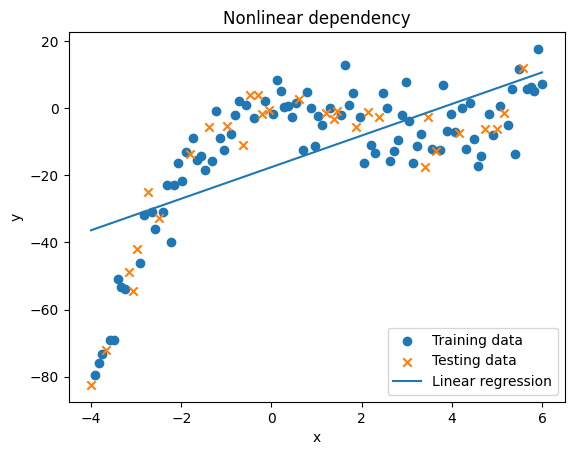

In [34]:
x_grid = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
y_grid_lin = lin_model.predict(x_grid)

plt.figure()
plt.scatter(X_train, y_train, label="Training data")
plt.scatter(X_test, y_test, label="Testing data", marker="x")
plt.plot(x_grid, y_grid_lin, label="Linear regression")
plt.title("Nonlinear dependency")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

In [35]:
poly = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('lin', LinearRegression())
])

param_grid = {
    'poly__degree': list(range(1, 11))
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=poly,
    param_grid=param_grid,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid.fit(X_train, y_train)
best_degree = grid.best_params_['poly__degree']
best_cv_rmse = -grid.best_score_

print(f"Best CV polynom degree: {best_degree}")
print(f"Best CV RMSE: {best_cv_rmse: .3f}")

Best CV polynom degree: 3
Best CV RMSE:  6.674


In [36]:
rows = []
for d in range(1, 11):
    pipe = Pipeline([
        ('poly', PolynomialFeatures(degree=d, include_bias=False)),
        ('lin', LinearRegression())
    ])
    pipe.fit(X_train, y_train)

    y_tr = pipe.predict(X_train)
    y_te = pipe.predict(X_test)

    rows.append(
        {
            'degree': d,
            'train_R2': r2_score(y_train, y_tr),
            'test_R2': r2_score(y_test, y_te),
            'train rmse': mean_squared_error(y_test, y_te) ** 0.5,
            'test rmse': mean_squared_error(y_test, y_te) ** 0.5
        }
    )

metrics_df = pd.DataFrame(rows).set_index('degree')
metrics_df


,train_R2,test_R2,train rmse,test rmse
degree,,,,
1,0.450546,0.455217,16.786894,16.786894
2,0.704931,0.773967,10.812949,10.812949
3,0.903714,0.958424,4.637437,4.637437
4,0.903853,0.958569,4.629372,4.629372
5,0.903918,0.958677,4.623310,4.623310
6,0.904090,0.958205,4.649683,4.649683
7,0.904791,0.955795,4.781855,4.781855
8,0.904865,0.955393,4.803545,4.803545
9,0.905612,0.956926,4.720245,4.720245


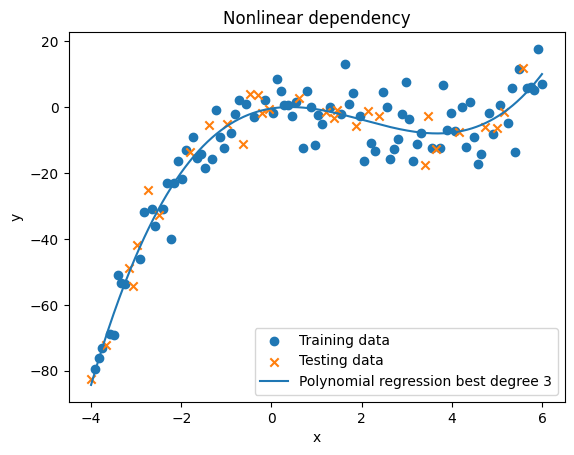

In [40]:
plt.figure()
x_dense = np.linspace(X.min(), X.max(), 400).reshape(-1, 1)
y_dense = grid.predict(x_dense)
plt.scatter(X_train, y_train, label="Training data")
plt.scatter(X_test, y_test, label="Testing data", marker="x")
plt.plot(x_dense, y_dense, label=f"Polynomial regression best degree {best_degree}")
plt.title("Nonlinear dependency")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

In [41]:
def fit_metrics_for_degree(d):
    pipe = Pipeline([
        ('poly', PolynomialFeatures(degree=d, include_bias=False)),
        ('lin', LinearRegression())
    ])
    pipe.fit(X_train, y_train)

    y_tr = pipe.predict(X_train)
    y_te = pipe.predict(X_test)

    return pipe, {
            'degree': d,
            'train_R2': r2_score(y_train, y_tr),
            'test_R2': r2_score(y_test, y_te),
            'train rmse': mean_squared_error(y_test, y_te) ** 0.5,
            'test rmse': mean_squared_error(y_test, y_te) ** 0.5
        }


model_low, m_low = fit_metrics_for_degree(1)
model_high, m_high = fit_metrics_for_degree(12)
model_best, m_best = fit_metrics_for_degree(best_degree)

pd.DataFrame([m_low, m_best, m_high])

,degree,train_R2,test_R2,train rmse,test rmse
0,1,0.450546,0.455217,16.786894,16.786894
1,3,0.903714,0.958424,4.637437,4.637437
2,12,0.907031,0.956783,4.728084,4.728084


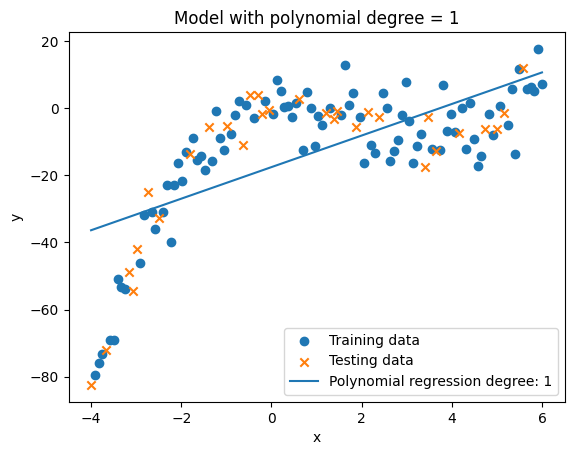

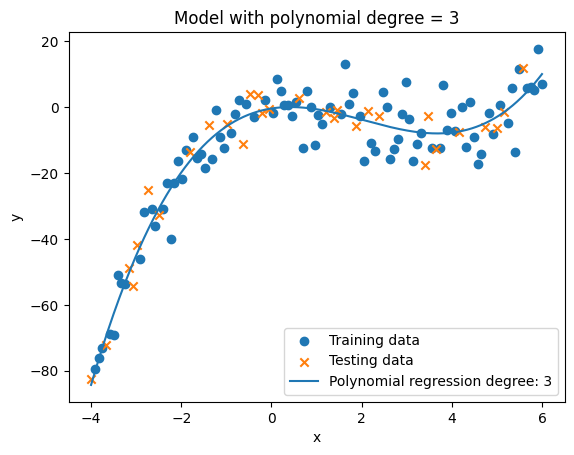

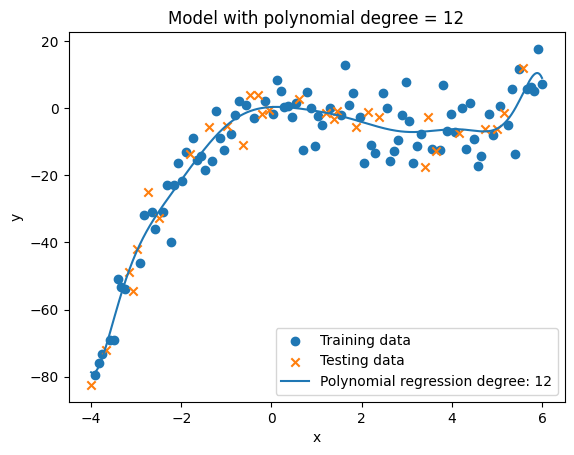

In [42]:
for d, model in [(1, model_low), (best_degree, model_best), (12, model_high)]:
    plt.figure()
    y_curve = model.predict(x_dense)
    plt.scatter(X_train, y_train, label="Training data")
    plt.scatter(X_test, y_test, label="Testing data", marker="x")
    plt.plot(x_dense, y_curve, label=f"Polynomial regression degree: {d}")
    plt.title(f"Model with polynomial degree = {d}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()